# Robot dance: a city-wise automatic control of Covid-19 mitigation levels

Robot dance is an automatic control system that considers a complex network of cities with working mobility between them during the period of an epidemic. 
It proposes a control framework that suggests the level of protective measures, in order to avoid the collapse of the health system. 
The model is the following: let a graph with $K$ cities, each one with population $N_i$, and

$$
S_i + E_i + I_i + R_i = 1, i=1,\dots,K.
$$

Let $\alpha(t)$ be a binary coefficient function with $\alpha(t) = 1$ in the time spent at the original node and $\alpha(t) = 0$ during the day. 
Set $T_{\mathrm{inc}}$ and $T_{\mathrm{inf}}$ the incubation and the infection periods. 
During the night, the system works as a SEIR model, written as

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i,
\end{split}
$$

But the cities have commuting, which changes the dynamic of infections.
Let $p_{ij}$ represent the percentage of individuals of node $i$ that work at $j$.
The orginal model consideres that $p_{ij}(t)$ is a function of the time which decreases linearly with $r_j(t)$. 
Here we treat it as a constant.
During the day, the effective population at $i$ is $P_i^{\mathrm{eff}} = \sum_{j=1}^K p_{ji} N_j$.

The number of working people from $i$ that get exposed to infectious individuals from $j$ is 

$$
p_{ij} S_i(t) I_j^{\mathrm{eff}}(t),
$$

where the effective infection ratio is 

$$
I_j^{\mathrm{eff}}(t) = \frac{1}{P_j^{\mathrm{eff}}} \sum_{k=1}^K p_{kj} I_k N_k,
$$

that represents the number of incoming infected individuals from the other cities to $j$ normalized by the effective population there. 

The equations are, therefore, 

$$
\begin{split}
\frac{dS_i}{dt} &= -\alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) - (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) \\
\frac{dE_i}{dt} &= \alpha(t)\left(\frac{r_i(t)}{T_{\mathrm{inf}}}S_i I_i\right) + (1-\alpha(t)) \left(\frac{S_i}{T_{\mathrm{inf}}} \sum_{j=1}^K r_j(t) p_{ij} I_j^{\mathrm{eff}}\right) - \frac{1}{T_{\mathrm{inc}}}E_i \\
\frac{dI_i}{dt} &= \frac{1}{T_{\mathrm{inc}}}E_i - \frac{1}{T_{\mathrm{inf}}}I_i \\
\frac{dR_i}{dt} &= \frac{1}{T_{\mathrm{inf}}}I_i.
\end{split}
$$

We can say that $r_i(t) = \beta_i(t)/\gamma = \beta_i(t) T_{\mathrm{inf}}$.
The variable $r_j(t)$ is the control variable that means the reproductive number at time $t$ at city $j$.
They minimize a function changing this function. 

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sympy as sp
from scipy.sparse.linalg import eigs, svds

Model code

In [2]:
def model_ode(t, y, alpha, beta, tau, gamma, population, p_matrix, population_eff, K):
    S, E, I, R = y[:K], y[K:2*K], y[2*K:3*K], y[3*K:]
    I_eff = (I * population) @ p_matrix / population_eff
    S_dot = -alpha(t) * beta * S * I - (1-alpha(t)) * S * (p_matrix @ (beta * I_eff))
    E_dot = -S_dot - tau * E
    I_dot = tau * E - gamma * I
    R_dot = gamma * I
    return np.hstack([S_dot, E_dot, I_dot, R_dot])

def hour_to_day(y, n_days):
    v = np.zeros((y.shape[0], n_days))
    values_per_day = int(y.shape[1]/n_days)
    for i in range(n_days):
        v[:,i] = np.mean(y[:,values_per_day*i:values_per_day*(i+1)], axis=1)
    return v

Here we consider a centralised city with its ramifications.
The big city is the center of the network. 
We suppose that 

$p_{0j} = 0.01, j = 1, \dots, K-1$, that is, one percent of the big city population goes to small city $j$.
Moreover, we suppose that $p_{j0} = 0.4$, that is, $40\%$ of the small cities go to the center.

In [3]:
K = 5
population = np.array([1e6, 1e4, 1e4, 1e4, 1e4])

p_0j = 0.01
p_j0 = 0.4


p_matrix = np.array([
    [1-4*p_0j, p_0j, p_0j, p_0j, p_0j],
    [p_j0, 1-p_j0, 0, 0, 0],
    [p_j0, 0, 1-p_j0, 0, 0],
    [p_j0, 0, 0, 1-p_j0, 0],
    [p_j0, 0, 0, 0, 1-p_j0]
])
population_eff = population @ p_matrix 

# working hours between 6 and 18 hours.
alpha = lambda t: 1.0 if t % 24 < 6 or t % 24 > 18 else 0.0
beta = np.array([0.5, 0.4, 0.4, 0.4, 0.4]) / 24
tau = 1/(5.2 * 24)
gamma = 1/(2.9 * 24)

args = (alpha, beta, tau, gamma, population, p_matrix, population_eff, K)

Initial conditions: 

$I_0(0) = 100/\phi_0, I_j(0) = 0$

In [4]:
y0 = np.zeros(4*K)
y0[:K] = 1
y0[K] = 100/1e6
y0[0] = 1-y0[K]

In [5]:
n_days = 300
t_eval = np.linspace(0, 24 * n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,24 * n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval,
               )

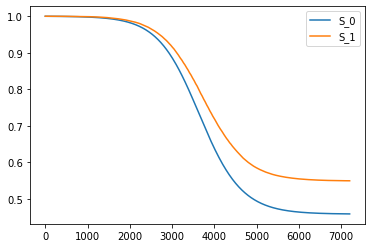

In [6]:
plt.plot(sol.t, sol.y[0], label='S_0')
plt.plot(sol.t, sol.y[1], label='S_1')
plt.legend()
plt.show()

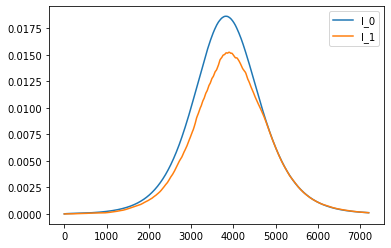

In [7]:
plt.plot(sol.t, sol.y[2*K], label='I_0')
plt.plot(sol.t, sol.y[2*K+2], label='I_1')
plt.legend()
plt.show()

Now, with different rates of commuting.

In [8]:
K = 5
population = np.array([1e6, 1e4, 1e4, 1e4, 1e4])

p_0j = 0.2
p_j0 = 0.01


p_matrix = np.array([
    [1-4*p_0j, p_0j, p_0j, p_0j, p_0j],
    [p_j0, 1-p_j0, 0, 0, 0],
    [p_j0, 0, 1-p_j0, 0, 0],
    [p_j0, 0, 0, 1-p_j0, 0],
    [p_j0, 0, 0, 0, 1-p_j0]
])
population_eff = population @ p_matrix 

# working hours between 6 and 18 hours.
alpha = lambda t: 1.0 if t % 24 < 6 or t % 24 > 18 else 0.0
beta = np.array([0.5, 0.4, 0.4, 0.4, 0.4]) / 24
tau = 1/(5.2 * 24)
gamma = 1/(2.9 * 24)

args = (alpha, beta, tau, gamma, population, p_matrix, population_eff, K)

In [9]:
n_days = 300
t_eval = np.linspace(0, 24 * n_days, 100 * n_days)

sol = solve_ivp(fun=lambda t, y: model_ode(t, y, *args),
                t_span=(0,24 * n_days),
                y0=y0,
                method='RK45',
                t_eval=t_eval, 
               )

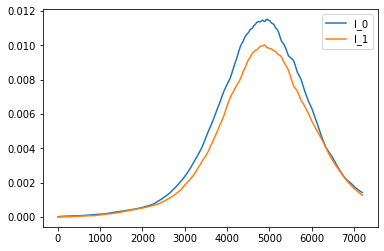

In [10]:
plt.plot(sol.t, sol.y[2*K], label='I_0')
plt.plot(sol.t, sol.y[2*K+2], label='I_1')
plt.legend()
plt.show()

## Calculating $\mathcal{R}_0$

In [51]:
def r0_calc(_beta, _populations, _P1, _alpha, _gamma):
    
    B = np.diag(_beta)
    N = np.diag(_populations)

    p_matrix = np.diag(1-_P1)
    p_matrix[:,0] += _P1

    population_eff = _populations @ p_matrix 
    E_inv = np.diag(1/population_eff)

    A = _alpha * B + (1-_alpha) * p_matrix @ B @ E_inv @ p_matrix.T @ N
    rho_A = abs(eigs(A, k=1, which='LM', return_eigenvectors=False)[0])
    return rho_A/gamma

In [21]:
K = 5

populations = np.array([7.0, 1.0, 1.0, 1.0, 1.0])
beta = np.array([0.7, 0.5, 0.5, 0.5, 0.5])

tau = 1/(5.2)
gamma = 1/(2.9)
alpha = 1/3


r0_list = np.zeros(100000)
P1_list = np.zeros_like(r0_list)
for i in range(100000):
    P1 = np.random.random(size=5)
    P1[0] = 1.0
    P1_list[i] = max(P1[1:])
    r0_list[i] = r0_calc(beta, populations, P1, alpha, gamma)

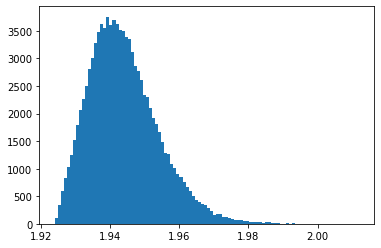

In [22]:
plt.hist(r0_list, bins=100)
plt.show()

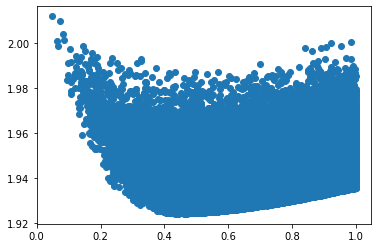

In [23]:
plt.scatter(P1_list, r0_list)

In [62]:
K = 3

populations = np.array([1.0, 0.1, 0.2])
beta = np.array([0.7, 0.5, 0.4])
P1 = np.array([1.0, 0.3, 0.3])

tau = 1/(5.2)
gamma = 1/(2.9)
alpha = 1/3

P1_list = np.linspace(0.0, 1.0, 10000, endpoint=False)

r0_list = np.zeros_like(P1_list)
for i, p21 in enumerate(P1_list):
    P1[2] = p21
    r0_list[i] = r0_calc(beta, populations, P1, alpha, gamma)

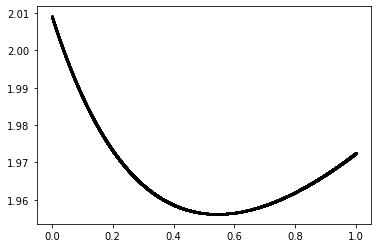

In [77]:
plt.scatter(P1_list, r0_list, s=2, color='black')
#plt.axhline(beta[0]/gamma, color='red')
#plt.plot([alpha_list[0], alpha_list[-1]], [r0_list[0], r0_list[-1]], color='red', linestyle='--')
plt.show()

## This is not quadratic or cubic! It may be another function.

In [300]:
gamma = 0.5
r0_list = np.zeros(100000)
r01_list = np.zeros(100000)
r0_differ = np.zeros_like(r0_list)

for i in range(100000):
    
    alpha = np.random.uniform(0, 1)
    populations = np.random.uniform(1, 100, size=5)
    populations = 100 * np.sort(populations)[::-1]
    
    beta = np.random.uniform(0.0, 0.8, size=5)
    beta[0] = np.random.uniform(max(beta), 0.8)
    
    P1 = np.random.uniform(0, 1, size=5)
    P1[0] = 1.0
    
    a = r0_calc(beta, populations, P1, alpha, gamma)
    r0_list[i] = a
    r01_list[i] = beta[0]/gamma
    
    populations = np.array([1.0, 1.0, 1.0, 1.0, 1.0])
    beta = np.array([0.7, 0.5, 0.5, 0.5, 0.5])
    b = r0_calc(beta, populations, P1, alpha, gamma)
    r0_differ[i] = b

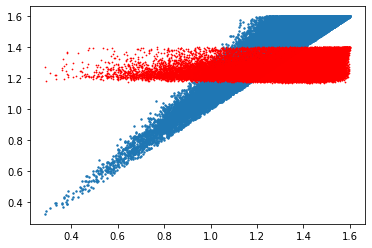

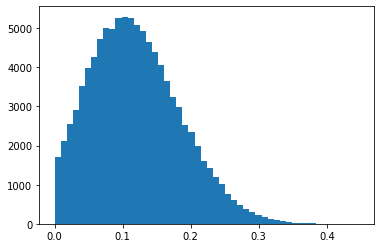

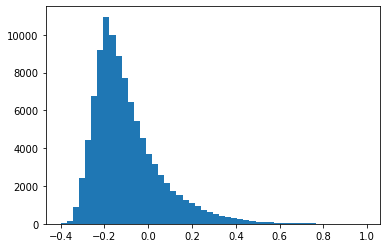

In [301]:
plt.scatter(r0_list, r01_list, s=2)
plt.scatter(r0_list, r0_differ, s=0.5, color='red')
plt.show()

plt.hist(r01_list - r0_list, bins=50)
plt.show()

plt.hist(r0_differ - r0_list, bins=50)
plt.show()

## Sympy code

In [78]:
p1, p2, p3, p4 = sp.symbols('p21 p31 p41 p51')
b1, b2, b3, b4, b5 = sp.symbols('b1 b2 b3 b4 b5')
n1, n2, n3, n4, n5 = sp.symbols('n1 n2 n3 n4 n5')
peff1, peff2, peff3, peff4, peff5 = sp.symbols('p^{eff}_1 p^{eff}_2 p^{eff}_3 p^{eff}_4 p^{eff}_5')
alpha = sp.symbols('alpha')
P = sp.Matrix([[1,0,0,0,0],
               [p1, 1-p1, 0,  0, 0],
               [p2, 0, 1-p2, 0, 0],
               [p3, 0, 0, 1-p3, 0],
               [p4, 0, 0, 0, 1-p4]])
B = sp.diag(b1, b2, b3, b4, b5)
N = sp.diag(n1, n2, n3, n4, n5)
E = sp.Matrix([[n1, n2, n3, n4, n5]])@P
E_inv = sp.diag(1/E[0], 1/E[1], 1/E[2], 1/E[3], 1/E[4])

M = sp.diag(0, b2*(1-p1), b3*(1-p2), b4*(1-p3), b5*(1-p4))
P1 = sp.Matrix([[1],[p1],[p2],[p3],[p4]])

#A = alpha*B + (1-alpha)*P@B@E_inv@P.T@N
A = alpha*B + (1-alpha)*M + b1*(1-alpha)/E[0]*P1@P1.T@N

In [91]:
N**(1/2)@P1@P1.T@N**(1/2)/E[0]

Matrix([
[            n1**1.0/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),     n1**0.5*n2**0.5*p21/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),     n1**0.5*n3**0.5*p31/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),     n1**0.5*n4**0.5*p41/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),     n1**0.5*n5**0.5*p51/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51)],
[n1**0.5*n2**0.5*p21/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),          n2**1.0*p21**2/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), n2**0.5*n3**0.5*p21*p31/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), n2**0.5*n4**0.5*p21*p41/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), n2**0.5*n5**0.5*p21*p51/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51)],
[n1**0.5*n3**0.5*p31/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), n2**0.5*n3**0.5*p21*p31/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),          n3**1.0*p31**2/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), n3**0.5*n4**0.5*p31*p41/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), n3**0.5*n5**0.5*p31*p51/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51)],
[n1**0.

In [48]:
A

Matrix([
[alpha*b1 + b1*n1*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),                                          b1*n2*p21*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),                                          b1*n3*p31*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),                                          b1*n4*p41*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),                                          b1*n5*p51*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51)],
[       b1*n1*p21*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51), alpha*b2 + b1*n2*p21**2*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51) + b2*(1 - alpha)*(1 - p21),                                      b1*n3*p21*p31*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),                                      b1*n4*p21*p41*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51),                                      b1*n5*p21*p51*(1 - alpha)/(n1 + n2*p21 + n3*p31 + n4*p41 + n5*p51)],
[    

In [30]:
p1 = sp.symbols('p21')
b1, b2 = sp.symbols('b1 b2')
n1, n2 = sp.symbols('n1 n2')
peff1, peff2= sp.symbols('p^{eff}_1 p^{eff}_2')
alpha = sp.symbols('alpha')
P = sp.Matrix([[1,0],
               [p1, 1-p1]])
B = sp.diag(b1, b2)
N = sp.diag(n1, n2)
E = sp.Matrix([[n1, n2]])@P
E_inv = sp.diag(1/E[0], 1/E[1])

M = sp.diag(0, b2*(1-p1))
D = sp.diag(0, n2*(1-p1)**2)

A = alpha*B + (1-alpha)*P@E_inv@B@P.T@N

In [40]:
sp.simplify(list(A.eigenvals().keys())[0])

(-alpha*b1*n2*p21**2 + alpha*b1*n2*p21 + alpha*b2*n1*p21 + alpha*b2*n2*p21**2 + b1*n1 + b1*n2*p21**2 - b2*n1*p21 + b2*n1 - b2*n2*p21**2 + b2*n2*p21 - sqrt(4*alpha**2*b1**2*n1*n2*p21**2 + alpha**2*b1**2*n2**2*p21**4 + 2*alpha**2*b1**2*n2**2*p21**3 + alpha**2*b1**2*n2**2*p21**2 - 2*alpha**2*b1*b2*n1*n2*p21**3 - 2*alpha**2*b1*b2*n1*n2*p21**2 - 2*alpha**2*b1*b2*n2**2*p21**4 - 2*alpha**2*b1*b2*n2**2*p21**3 + alpha**2*b2**2*n1**2*p21**2 + 2*alpha**2*b2**2*n1*n2*p21**3 + alpha**2*b2**2*n2**2*p21**4 - 6*alpha*b1**2*n1*n2*p21**2 + 2*alpha*b1**2*n1*n2*p21 - 2*alpha*b1**2*n2**2*p21**4 - 2*alpha*b1**2*n2**2*p21**3 - 2*alpha*b1*b2*n1**2*p21 + 4*alpha*b1*b2*n1*n2*p21**3 - 2*alpha*b1*b2*n1*n2*p21**2 - 2*alpha*b1*b2*n1*n2*p21 + 4*alpha*b1*b2*n2**2*p21**4 - 2*alpha*b1*b2*n2**2*p21**2 - 2*alpha*b2**2*n1**2*p21**2 + 2*alpha*b2**2*n1**2*p21 - 4*alpha*b2**2*n1*n2*p21**3 + 4*alpha*b2**2*n1*n2*p21**2 - 2*alpha*b2**2*n2**2*p21**4 + 2*alpha*b2**2*n2**2*p21**3 + b1**2*n1**2 + 2*b1**2*n1*n2*p21**2 + b1**2*n2**2*

In [276]:
sp.simplify(alpha*B + (1-alpha)*P@B)

Matrix([
[                b1,                        0,                        0,                        0,                        0],
[b1*p21*(1 - alpha), b2*(alpha*p21 - p21 + 1),                        0,                        0,                        0],
[b1*p31*(1 - alpha),                        0, b3*(alpha*p31 - p31 + 1),                        0,                        0],
[b1*p41*(1 - alpha),                        0,                        0, b4*(alpha*p41 - p41 + 1),                        0],
[b1*p51*(1 - alpha),                        0,                        0,                        0, b5*(alpha*p51 - p51 + 1)]])